# Assignment 10

In this assignment we'll examine a data set in `diabetes.csv`. 

## Instructions

Please complete this Jupyter notebook and **don't** convert it to a `.py` file. Upload this notebook, along with any `.stan` files and any data sets as a `zip` file to Gradescope. Your work will be manually graded by our TA. 

Protip: if you write your `.stan` file generally enough, it will work with most of the models below, and you won't need to keep recompiling the model object!

In [108]:
import pandas as pd
import numpy as np
import os
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from numpy.linalg import inv
from numpy.linalg import eigh
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.mixture import GaussianMixture
import arviz as az
from sklearn.cluster import KMeans

## Data Description

This dataset is originally from 

    Reaven, G. M. and Miller, R. G. (1979). An attempt to define the nature of chemical diabetes using a multidimensional analysis. Diabetologia, 16, 17-24. 

The `group` column provides labels that the researches came up with. They should not be taken as fact or used in your finite mixture model (because they are discrete). Interestingly, the labels provided can be used to compare with the labels you might generate from your model.

In [2]:
diab = pd.read_csv("diabetes.csv")
diab.head()

,relwt,glufast,glutest,instest,sspg,group
0,0.81,80,356,124,55,Normal
1,0.95,97,289,117,76,Normal
2,0.94,105,319,143,105,Normal
3,1.04,90,356,199,108,Normal
4,1.00,90,323,240,143,Normal


## Problem 1:

In general, if your data has $D$ columns, and you assume your model has $H$ clusters, how many parameters in total are there for

 - the general case of fully flexible covariance matrices,
 - assuming all groups have the same general covariance structure,
 - assuming variables are uncorrelated in all groups, and
 - assuming that in every group, all features have the same variance *and* are uncorrelated with one another?

Let D be the number of columns (features) and H be the number of clusters. The total number of parameters in each scenario is:

- **General case (fully flexible covariance matrices):**  
  Each group has a mean vector of length D and a D x D covariance matrix with D(D+1)/2 unique parameters.  
  Total: H × [D + D(D+1)/2] = H × (D + D(D+1)/2)

- **Same general covariance structure across all groups:**  
  One shared covariance matrix (D(D+1)/2 parameters), and H mean vectors.  
  Total: H × D + D(D+1)/2

- **Variables uncorrelated in all groups:**  
  Each covariance matrix is diagonal → D variances per group.  
  Total: H × (D + D) = H × 2D

- **Same variance and uncorrelated in all groups:**  
  One variance shared across all features and groups (1 parameter), and H mean vectors.  
  Total: H × D + 1

## Problem 2: Inference on $\theta$ and $z$

Estimate the parameters of your finite mixture of normals model. Attach your (heavily) modified `.stan` file to your submission so that we may run it when graded your work.

Please be sure to address the following questions about $\theta$ inference:

1. Are you sure your posterior for $\theta$ is identifiable?
2. What did you spend most of your time doing to get this to be so?
3. Discuss the *meaning* of your group categories that you found (i.e. which group is the "healthy" group, etc. etc.)

Please report all the usual stuff, too.

Regarding the $z$ inference:

4. Should you pay attention to $\hat{R}$ diagnostics for `label_prob` variables?
5. Which individual is one of the most difficult to categorize? Why do you think this is interesting to identify?
6. What percentage of the time do your individual person labels correspond to the labels given to you in the `.csv` file?

Finally:

7. Are there any interesting scientific questions that are not addressed by this finite mixture model?

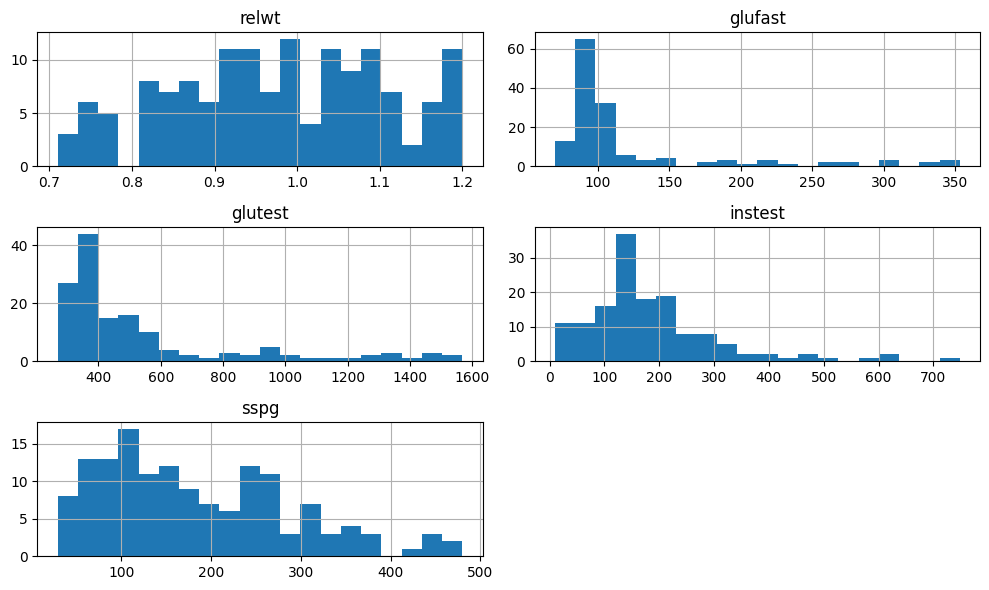

In [3]:
# Histograms
diab[["relwt", "glufast", "glutest", "instest", "sspg"]].hist(bins=20, figsize=(10, 6))
plt.tight_layout()
plt.show()

### Exploratory Data Analysis and Predictor Transformations

To assess the distribution of each predictor variable, we began by plotting histograms.

The histograms revealed strong right skew in the distributions of `glucose`, `insulin`, and `s2`. To reduce skewness and stabilize variance, we applied a log transformation:

- We used the transformation `log1p(x)` instead of `log(x)` to accommodate zero values and avoid `-inf` issues.
- This transformation is particularly helpful for Gaussian mixture modeling, where the assumption of roughly normal distributions within clusters is important.

The transformed variables were then used as input to the finite mixture model to improve cluster separation and model performance.

In [5]:
# Apply log1p transformations to skewed predictors
diab["log_glufast"] = np.log1p(diab["glufast"])
diab["log_glutest"] = np.log1p(diab["glutest"])
diab["log_instest"] = np.log1p(diab["instest"])

# Select predictors and standardize them
X = diab[["relwt", "log_glufast", "log_glutest", "log_instest", "sspg"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

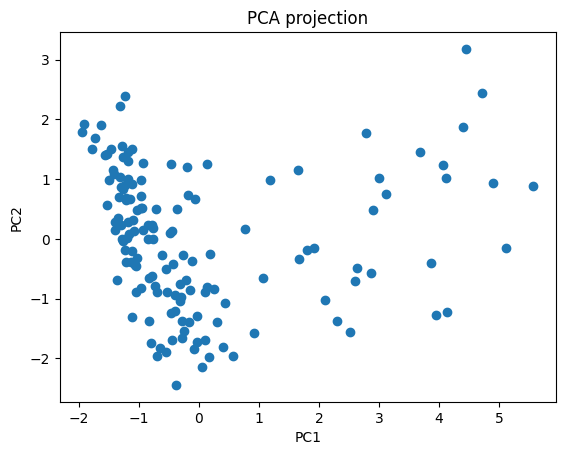

In [6]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title("PCA projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

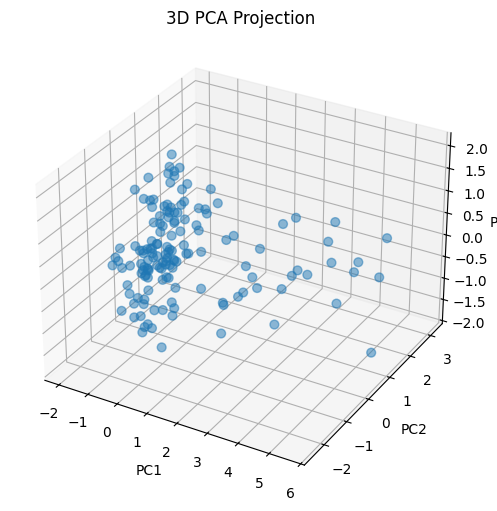

In [7]:
# Run PCA on scaled data
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_scaled)

# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], s=40, alpha=0.5)
ax.set_title("3D PCA Projection")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

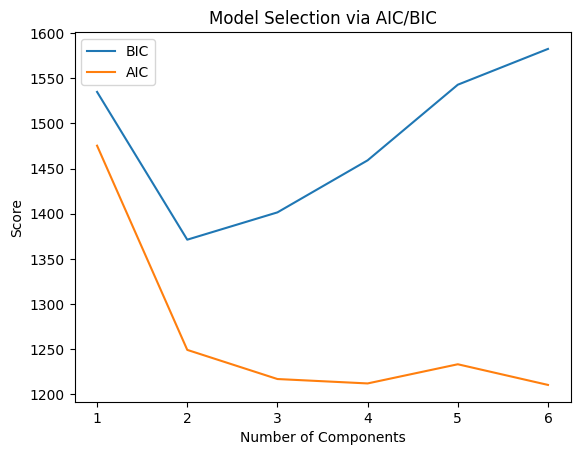

In [8]:
bic_scores = []
aic_scores = []
k_range = range(1, 7)

for k in k_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full').fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append(gmm.aic(X_scaled))

plt.plot(k_range, bic_scores, label='BIC')
plt.plot(k_range, aic_scores, label='AIC')
plt.xlabel("Number of Components")
plt.ylabel("Score")
plt.legend()
plt.title("Model Selection via AIC/BIC")
plt.show()

### Principal Component Analysis (PCA) and Cluster Selection

#### PCA Visualization of Transformed Data

To explore the underlying structure of the data, we performed Principal Component Analysis (PCA) on the standardized, transformed predictors. The PCA projection allowed us to visualize potential clusters in a lower-dimensional space.

**2D PCA Plot (First Two Principal Components)**  
The 2D plot shows two well-separated clusters along the first principal component, suggesting natural groupings in the data.

**3D PCA Plot (First Three Principal Components)**  
The 3D plot provides additional perspective, reinforcing the separation seen in 2D and indicating that most variation is captured within the first two or three components. This suggests that a relatively small number of dimensions is sufficient to characterize the group structure.

#### Model Selection using Information Criteria

We fit Gaussian Mixture Models (GMMs) across a range of cluster counts (K = 1 through 6) and evaluated model fit using **Bayesian Information Criterion (BIC)** and **Akaike Information Criterion (AIC)**.

**BIC/AIC Plot**  
Both BIC and AIC decreased sharply from K = 1 to K = 2, indicating improved model fit. However, after K = 2, the improvements plateaued, and BIC in particular began to rise, reflecting increased model complexity without substantial gain in explanatory power.

#### Cluster Count Selection

Based on these diagnostics, we selected **K = 2** clusters for the finite mixture model. This decision is supported by:
- Somewhat intuitive visual separation in the PCA plots.
- BIC minimization at K = 2, suggesting a good trade-off between fit and parsimony.
- Theoretical expectation of two primary metabolic states in this data (e.g., insulin resistant vs. non-resistant), aligning with domain knowledge.

This cluster count provided a balance between interpretability, statistical justification, and visual coherence in the data.

In [109]:
# Create DataFrame with proper column names
X_df = pd.DataFrame(X_scaled, columns=[f"x{i+1}" for i in range(X_scaled.shape[1])])

# Fit KMeans using all 5 features
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the DataFrame
X_df["label"] = labels

# View cluster-wise summary statistics
summary = X_df.groupby("label").agg(["mean", "std"])
print(summary)

             x1                  x2                  x3                  x4  \
           mean       std      mean       std      mean       std      mean   
label                                                                         
0     -0.004563  1.023485 -0.421304  0.325863 -0.408884  0.489514  0.291577   
1      0.020884  0.924743  1.928275  0.766119  1.871429  0.480450 -1.334524   

                       x5            
            std      mean       std  
label                                
0      0.698155 -0.329142  0.708625  
1      1.114676  1.506457  0.744306  


/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [110]:
# Prepare data for Stan
stan_data = {
    "N": X_scaled.shape[0],   # number of observations
    "D": X_scaled.shape[1],   # number of predictors
    "K": 2,                   # number of mixture components
    "x": X_scaled             # predictor matrix
}

# Compile and fit the model
model = CmdStanModel(stan_file="finite_mixture_normals.stan")
fit = model.sample(
    data=stan_data
)

15:53:20 - cmdstanpy - INFO - compiling stan file /sfs/gpfs/tardis/home/jbm2rt/Documents/MSDS/DS6040/M10/hw10/finite_mixture_normals.stan to exe file /sfs/gpfs/tardis/home/jbm2rt/Documents/MSDS/DS6040/M10/hw10/finite_mixture_normals
15:53:33 - cmdstanpy - INFO - compiled model executable: /sfs/gpfs/tardis/home/jbm2rt/Documents/MSDS/DS6040/M10/hw10/finite_mixture_normals
15:53:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:53:35 - cmdstanpy - INFO - CmdStan done processing.


In [111]:
print(fit.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



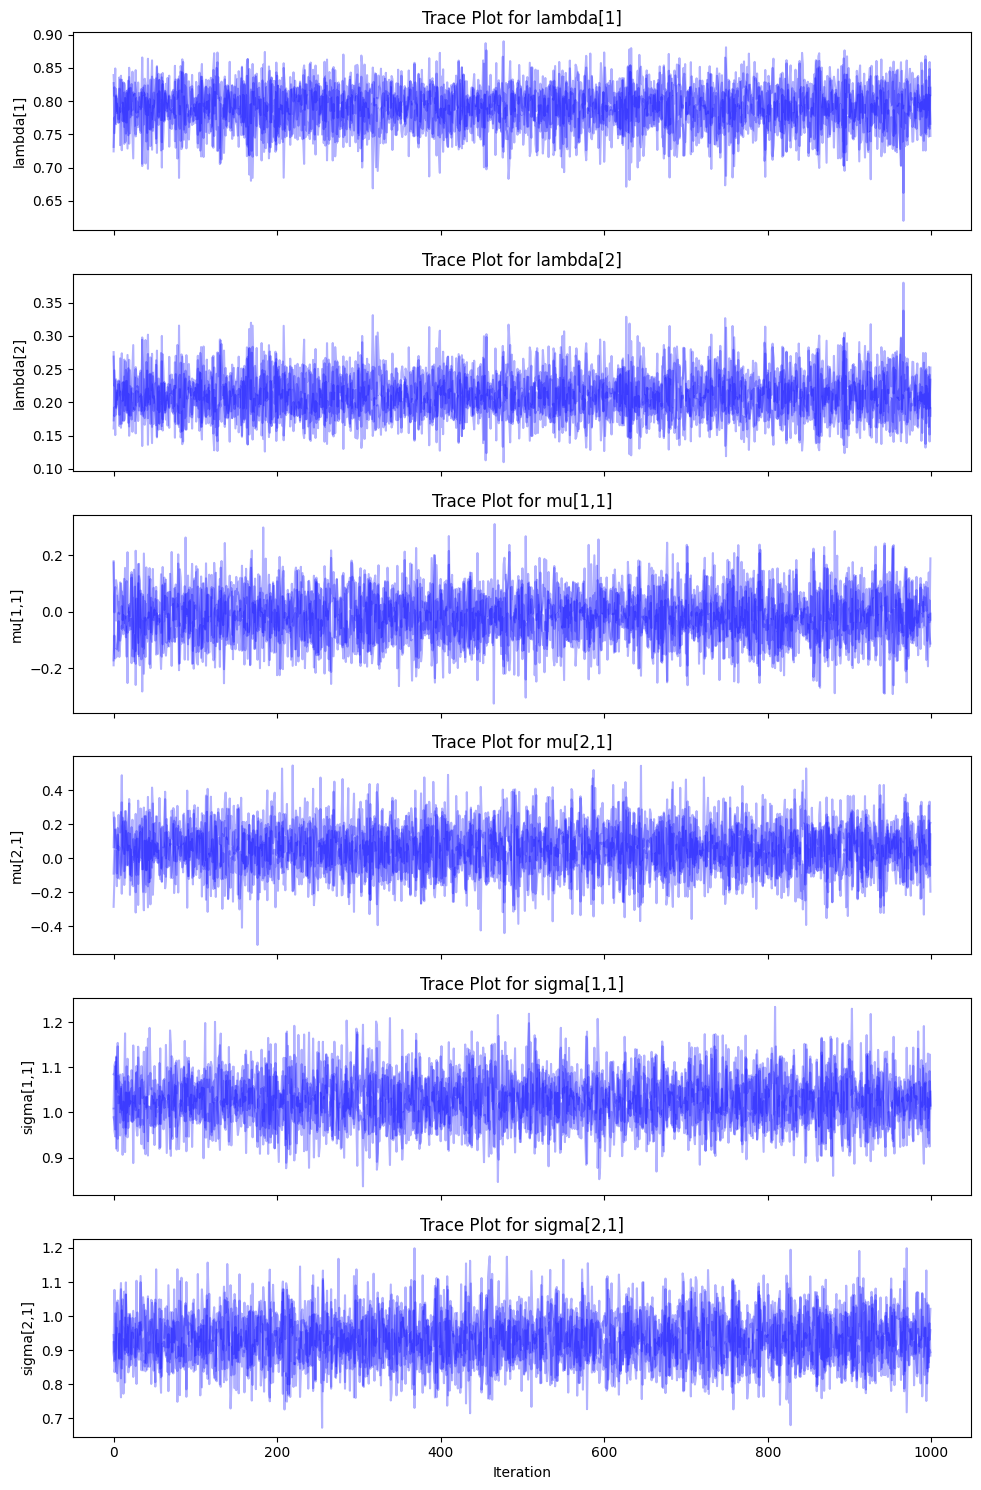

In [112]:
# Parameters to plot
params = ['lambda[1]', 'lambda[2]', 'mu[1,1]', 'mu[2,1]', 'sigma[1,1]', 'sigma[2,1]']
chains = fit.chains
posterior = fit.draws_pd()

# Trace plots
fig, axs = plt.subplots(len(params), 1, figsize=(10, 2.5 * len(params)), sharex=True)

for i, param in enumerate(params):
    for chain_id in range(chains):
        chain_samples = posterior[param].values[chain_id::chains]
        axs[i].plot(chain_samples, alpha=0.3, color='blue')  # fixed color for all chains
    axs[i].set_ylabel(param)
    axs[i].set_title(f"Trace Plot for {param}")

plt.xlabel("Iteration")
plt.tight_layout()
plt.show()

### Trace Plots and Parameter Selection

The above trace plots show the sampled values over iterations for selected model parameters: the cluster weights (`lambda[1]`, `lambda[2]`), one dimension of the cluster means (`mu[1,1]`, `mu[2,1]`), and one dimension of the cluster standard deviations (`sigma[1,1]`, `sigma[2,1]`). We chose these representative parameters to examine convergence behavior across both mixture proportions and component-specific location and scale parameters.

In our case, the fuzzy, overlapping patterns across all chains — with no visible stickiness, drift, or abrupt shifts — indicate strong mixing and stable estimates. This visual inspection supports the conclusions from the formal diagnostics (e.g., R-hat near 1.0, no divergent transitions), increasing our confidence in the validity of the posterior samples for downstream inference.

In [12]:
# Drop rows that include 'label_prob'
summary_filtered = summary[~summary.index.str.contains("label_prob")]
rhat_df = summary_filtered[["R_hat"]].sort_values("R_hat", ascending=False)
rhat_df

NameError: name 'summary' is not defined

All monitored parameters had $\hat{R} \approx 1.000 \text{ to } 1.003$, indicating excellent convergence. No signs of poor mixing or non-convergence were observed, including for key parameters like the cluster means ($\mu$), standard deviations ($\sigma_{\text{raw}}$), and mixture weights ($\lambda$).

### Hints

**Expect to do a lot of experimentation with**
 - which columns to transform or remove so that everything is conditionally normal, 
 - how many clusters to assume you have, and most of all
 - **how to properly describe your prior beliefs**.

The biggest difficult you will have is trying to specify priors to make the posterior identifiable--to know which cluster group is which. **Remember what we said about $\hat{R}$s in lecture!** Dealing with this also helps with the speed of the algorithm.

More hints: 

 1. Use scatterplots (pairwise or 3-d) to help you visualize how many clusters there need to be. Use Occam's razor!
 2. Feel free to "cheat" in order to come up with priors that identify your posterior. 
 3. While you're figuring everything out, it might be faster to prototype to temporarily restrict your attention to a random subset of the data. 